## XSBench
A mini-app representing a key computational kernel of the
Monte Carlo neutronics application OpenMC.  
  
  ---
clang++-5.0.1 -std=gnu99 -march=native -fopenmp -g -O3  

Exec Line:  
./XSBench -l 150000000
  
(**Haswell**) Intel(R) Xeon(R) CPU E5-2699 v3 @ 2.30GHz  

`divsd`: 10-20 Cycles  
`mulsd`: 5 Cycles  
`movsd`: 3 Cycles  
L1 Cache: 32 kB, 8 way, 64 sets, 64 B line size, **latency 4**, per core.    
L2 Cache: 256 kB, 8 way, 512 sets, 64 B line size, **latency 12**, per core.  
L3 Cache: 45 MB, 12-16 way, 64 B line size, **latency 34**, shared.  
Branch Misprediction Penalty: **15 - 20 cycles**.  
Data from Agner

| Empirical Roofline Toolkit | L1 Cache | L2 Cache | L3 Cache | DRAM |
|:---|:------:|:--------:|:----------:|:-----|
|Cache Lines / Cycle | .9715 | .3050 | 0.2188 | 0.1067 |

---
#### `XSutils.c::binary_search( )`:

|`Loop at Line 59`|  CPUTIME  | Inst per Cycle | L1 DC Miss % | L2 DC Miss % | L3 Miss % | L1 Loads/Cycle | L2 B/W Used | L3 B/W Used | Branch MSP % |
|:-----|:------:|:-------:|:-----------------------:|:---:|:---:|:---:|:---:|:---:|:---:|
| **Serial Run** | 44.5% | 0.38 | 13.8% | 84.1% | < .1% | 0.10 | 5.5% | 6.4% |3.7% | 
| **72 Thread Run** | 14.8% | 0.87 |12.1% | 99.3% | < .1% | 0.32 | 15.4% | 21.4% | 1.8% |

```c
|44|// Binary Search function for nuclide grid
|45|// Returns ptr to energy less than the quarry that is closest to the quarry
|46|int binary_search( NuclideGridPoint * A, double quarry, int n )
|47|{       
|48|	int min = 0;
|49|	int max = n-1;
|50|	int mid;
|51|	
|52|	// checks to ensure we're not reading off the end of the grid
|53|	if( A[0].energy > quarry )                          
|54|		return 0;
|55|	else if( A[n-1].energy < quarry )
|56|		return n-2;
|57|
```

|`Loop at Line 59`|  CPUTIME  | Inst per Cycle | L1 DC Miss % | L2 DC Miss % | L3 Miss % | L1 Loads/Cycle | L2 B/W Used | L3 B/W Used | Branch MSP % |
|:-----|:------:|:-------:|:-----------------------:|:---:|:---:|:---:|:---:|:---:|:---:|
| **Serial Run** | 32.8% | 0.29 | 10.0% | 84.6% | < .1% | 0.11 | 4.4% | 5.2% | 0.5% |
| **72 Thread Run** | 11.2% | 0.88 | 9.9%| 99.0%| < .1% | 0.32 | 9.0% | 12.5% | 1.8% |
```c
|58|	// Begins binary search	
|59|	while( max >= min )
|60|	{    
|61|        	mid = min + floor( (max-min) / 2.0);
|62|		if( A[mid].energy < quarry )   
|63|			min = mid+1;
|64|		else if( A[mid].energy > quarry )
|65|			max = mid-1;
|66|		else
|67|			return mid;
|68|	}
|69|       	return max;
|70|}
```

---
#### CalculateXS.c::calculate_micro_xs( )

|`calculate_micro_xs()`|  CPUTIME  | Inst per Cycle | L1 DC Miss % | L2 DC Miss % | L3 Miss % | L1 Loads/Cycle | L2 B/W Used | L3 B/W Used | DRAM B/W Used| Branch MSP % |
|:-----|:------:|:-------:|:-----------------------:|:---:|:---:|:---:|:---:|:---:|:---:|
| **Serial Run** | 22.3% | 0.35 | 23.4% | 81.4% | 39.9% | 0.13 | 12.2% | 13.9% | 11.1% | < 0.1% |
| **72 Thread Run** | 60.5% | 0.20 | 22.8% | 89.4% | 53.3% | 0.08| 5.6% | 6.9% | 7.6%| < 0.1% | 
```c
  3 // Calculates the microscopic cross section for a given nuclide & energy
  4 void calculate_micro_xs(   double p_energy, int nuc, long n_isotopes,
  5                            long n_gridpoints,
  6                            GridPoint * restrict energy_grid,
  7                            NuclideGridPoint ** restrict nuclide_grids,
  8                            long idx, double * restrict xs_vector, int grid_type ){
  9 
 10         // Variables
 11         double f;
 12         NuclideGridPoint * low, * high;
 13 
 14         // If using only the nuclide grid, we must perform a binary search
 15         // to find the energy location in this particular nuclide's grid.
 16         if( grid_type == NUCLIDE )
 17         {
 18                 // Perform binary search on the Nuclide Grid to find the index
 19                 idx = grid_search_nuclide( n_gridpoints, p_energy, nuclide_grids[nuc]);
 20 
 21                 // pull ptr from nuclide grid and check to ensure that
 22                 // we're not reading off the end of the nuclide's grid
 23                 if( idx == n_gridpoints - 1 )
 24                         low = &nuclide_grids[nuc][idx - 1];
 25                 else
 26                         low = &nuclide_grids[nuc][idx];
 27         }
 28         else // Unionized Energy Grid - we already know the index, no binary search needed.
 29         {
 30                 // pull ptr from energy grid and check to ensure that
 31                 // we're not reading off the end of the nuclide's grid
 32                 if( energy_grid[idx].xs_ptrs[nuc] == n_gridpoints - 1 )
 33                         low = &nuclide_grids[nuc][energy_grid[idx].xs_ptrs[nuc] - 1];
 34                 else
 35                         low = &nuclide_grids[nuc][energy_grid[idx].xs_ptrs[nuc]];
 36         }
 37 
 38         high = low + 1;
 39 
 40         // calculate the re-useable interpolation factor
 41         f = (high->energy - p_energy) / (high->energy - low->energy);
 42 
 43         // Total XS
 44         xs_vector[0] = high->total_xs - f * (high->total_xs - low->total_xs);
 45 
 46         // Elastic XS
 47         xs_vector[1] = high->elastic_xs - f * (high->elastic_xs - low->elastic_xs);
 48 
 49         // Absorbtion XS
 50         xs_vector[2] = high->absorbtion_xs - f * (high->absorbtion_xs - low->absorbtion_xs);
 51 
 52         // Fission XS
 53         xs_vector[3] = high->fission_xs - f * (high->fission_xs - low->fission_xs);
 54 
 55         // Nu Fission XS
 56         xs_vector[4] = high->nu_fission_xs - f * (high->nu_fission_xs - low->nu_fission_xs);
            (...)
 69 }
```

---
### Strong Scaling 1 to 72 Threads

In [7]:
import matplotlib; import matplotlib.pyplot as plt
%matplotlib inline

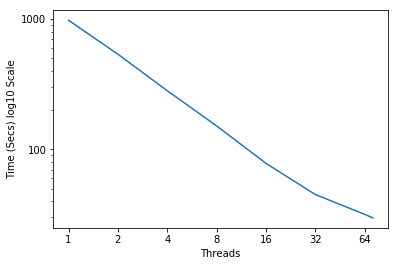

In [5]:
fig, ax = plt.subplots(); ax.set_xscale('log', basex=2); ax.set_yscale('log', basey=10)
ax.set_xlabel('Threads'); ax.set_ylabel('Time (Secs) log10 Scale'); ax.set_xticks([1,2,4,8,16,32,64])
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.set_yticks([10, 100, 1000]); ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.plot([1,2,4,8,16,32,64,72], [978.395, 536.988, 281.842, 151.496, 78.176, 45.060, 31.748, 29.771])

plt.show()